In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from  statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.rcParams["figure.figsize"] = [18, 8]

# Этот набор данных содержит информацию о погоде в городе Дели(Индия)
# с 1 января 2013 года по 24 апреля 2017 года.
Данные имеют несколько параметров:
1) Дата (date);
2) Влажность (humidity);
3) Средняя температура (meantemp);
4) Скорость ветра (wind_speed);
5) Среднее давление (meanpressure).

In [9]:
df_train = pd.read_csv('data/DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)
df_test = pd.read_csv('data/DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)
df = pd.concat([df_train, df_test])

Посмотрим данные:

In [10]:
print(f'Кол-во строк в тренировочных данных: {len(df_train)}')
print(f'Кол-во строк в тестовых данных: {len(df_test)}')
print(f'Кол-во строк во всем датасете: {len(df)}')

Кол-во строк в тренировочных данных: 1462
Кол-во строк в тестовых данных: 114
Кол-во строк во всем датасете: 1576


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1576 entries, 2013-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1576 non-null   float64
 1   humidity      1576 non-null   float64
 2   wind_speed    1576 non-null   float64
 3   meanpressure  1576 non-null   float64
dtypes: float64(4)
memory usage: 61.6 KB


Все столбцы имеют тип float

In [12]:
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Пропусков в тренировочных данных нет.

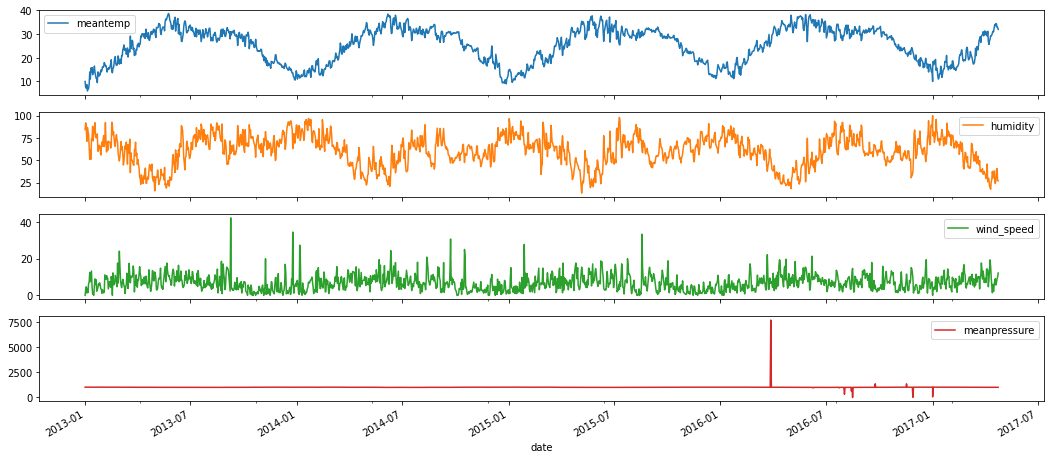

In [13]:
df.plot(subplots=True)
plt.show()

In [14]:
for c in df.columns:
    af = adfuller(df[c])
    print(c)
    print(f'adf: {af[0]}')
    print(f'p-value: {af[1]}')
    print(f'Critical values: {af[4]}')
    if af[0] > af[4]['5%']:
        print('Ряд не стационарен')
    else:
        print('Ряд стационарен')
    print('\n')

meantemp
adf: -2.3791899484520926
p-value: 0.14769623489792355
Critical values: {'1%': -3.4345353407734733, '5%': -2.86338857621683, '10%': -2.567754150088293}
Ряд не стационарен


humidity
adf: -3.6289421593858777
p-value: 0.005231221485558025
Critical values: {'1%': -3.4345487774977768, '5%': -2.8633945067663817, '10%': -2.5677573081032214}
Ряд стационарен


wind_speed
adf: -4.01322099000784
p-value: 0.0013428427295095503
Critical values: {'1%': -3.434573182279212, '5%': -2.863405278205157, '10%': -2.567763043900464}
Ряд стационарен


meanpressure
adf: -39.54736593013774
p-value: 0.0
Critical values: {'1%': -3.434508723681996, '5%': -2.863376828187341, '10%': -2.567747894280675}
Ряд стационарен




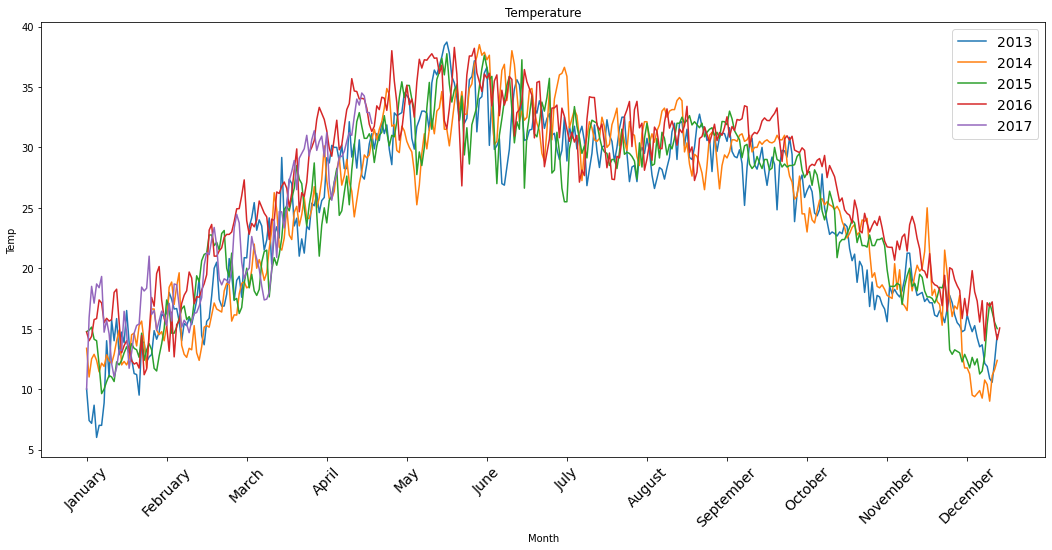

In [15]:
dates = pd.to_datetime(df.index)
plt.title('Temperature')
for y in dates.year.unique():
    plt.plot(df['meantemp'][dates.year==y].values, label=y)
plt.xlabel('Month')
plt.ylabel('Temp')
plt.xticks(np.arange(0, 365, 32), labels=dates.month_name().unique(), rotation=45, fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [32]:
df_m = pd.DataFrame(df_train['meantemp'].resample('M').mean())

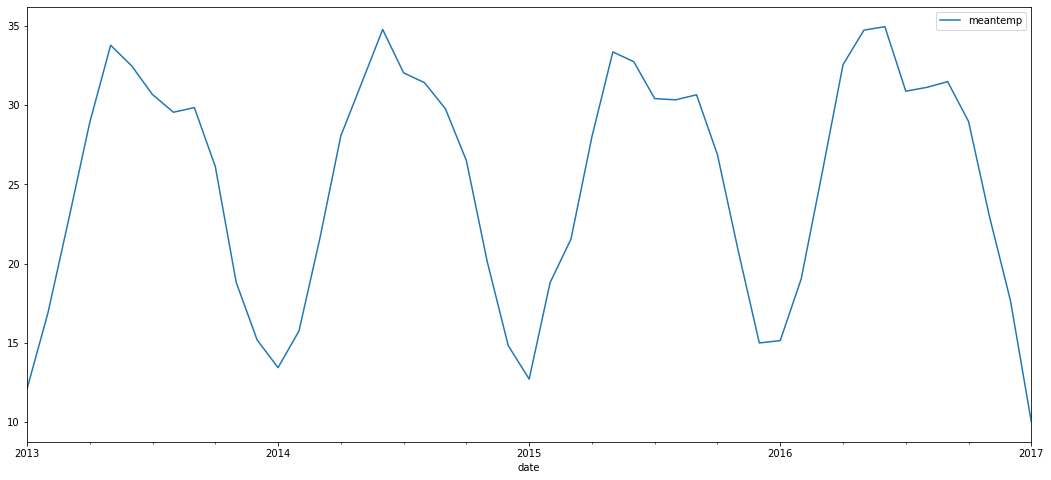

In [33]:
df_m.plot()
plt.show()

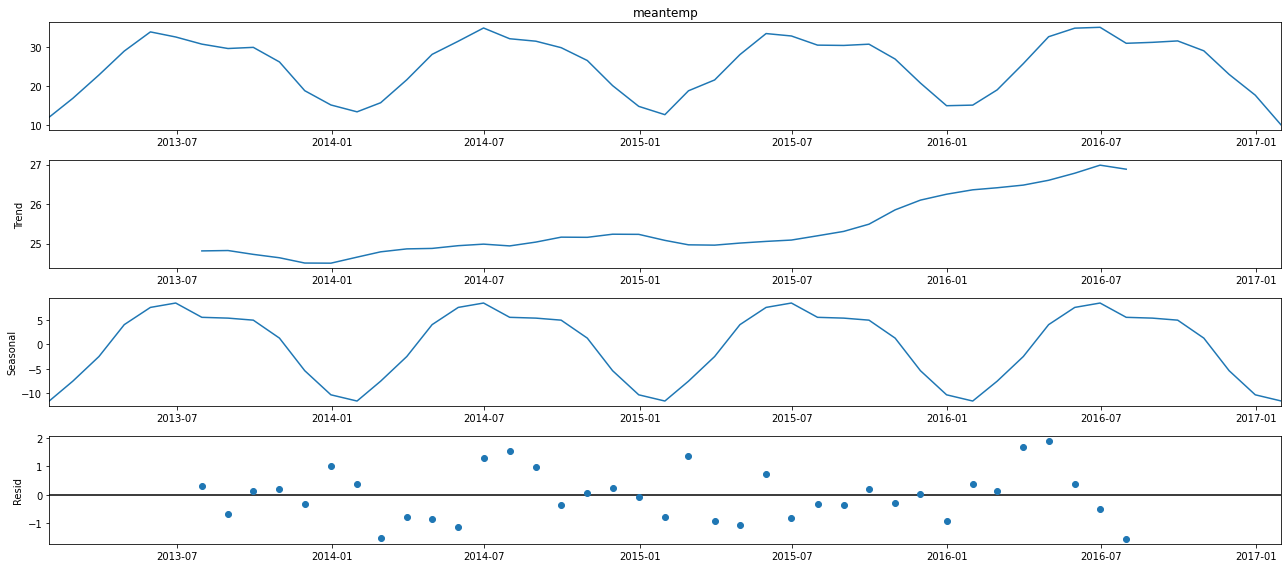

In [34]:
decomp = seasonal_decompose(df_m['meantemp'])
decomp.plot()
plt.show()

In [122]:
model = SARIMAX(df_m,
                  order=(2,0,2),
                  seasonal_order=(2,1,0,12))
results=model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            meantemp   No. Observations:                   49
Model:             SARIMAX(2, 0, 2)x(2, 1, [], 12)   Log Likelihood                 -67.034
Date:                             Tue, 19 Apr 2022   AIC                            148.067
Time:                                     16:53:24   BIC                            159.344
Sample:                                 01-31-2013   HQIC                           152.043
                                      - 01-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8779      0.222      3.958      0.000       0.443       1.313
ar.L2         -0.6574      

D:\PythonProject\TimeSeriesItmo\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


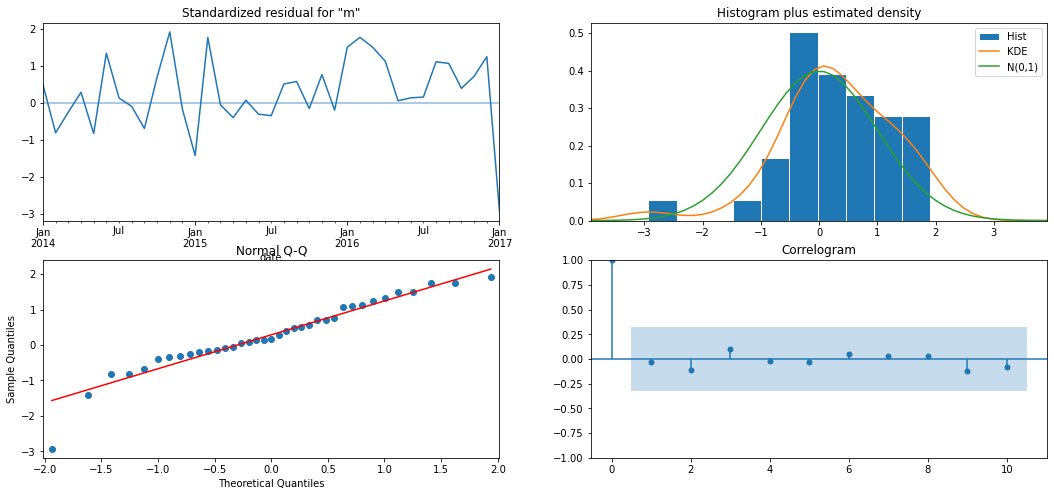

In [148]:
results.plot_diagnostics()
plt.show()

In [141]:
df_test_m = pd.DataFrame(df_test['meantemp'].resample('M').mean())
predictions= results.get_forecast(steps=24).predicted_mean

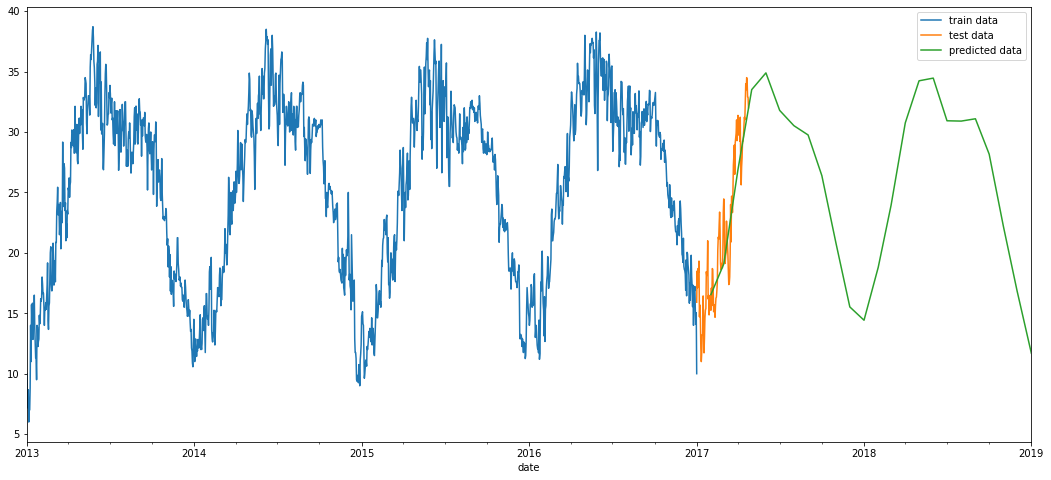

In [142]:
fig, ax = plt.subplots()
df_train['meantemp'].plot(legend=True)
df_test['meantemp'].plot(legend=True)
predictions.plot(legend=True)
ax.legend(['train data', 'test data', 'predicted data'])
plt.show()

In [147]:
mse = mean_squared_error(df_test_m, predictions[:4])
print(f'MSE = {mse}')

MSE = 4.651549403759187


In [146]:
rmse = np.sqrt(mse)
print(f'RMSE = {rmse}')

RMSE = 2.156745094757187
